# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [ ]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

In [2]:
!pip list

Package                       Version
----------------------------- ------------
absl-py                       1.4.0
aiohttp                       3.8.5
aiosignal                     1.3.1
albumentations                1.3.1
anyio                         4.0.0
appdirs                       1.4.4
appnope                       0.1.3
argon2-cffi                   23.1.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
asttokens                     2.4.0
astunparse                    1.6.3
async-lru                     2.0.4
async-timeout                 4.0.3
attrs                         23.1.0
Babel                         2.12.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.5
beautifulsoup4                4.12.2
bleach                        6.0.0
blinker                       1.6.2
brotlipy                      0.7.0
cached-property               1.5.2
cachetools                    5.3.1
certifi                       2023.7.22
cffi      

### 1.2 Collect Images Using OpenCV

In [19]:
import os
import time
#uuid - to generate unique phone id 
import uuid
import cv2

In [36]:
IMAGE_PATHS = os.path.join('data', 'images')

# count of images to collect
number_images = 30

In [37]:
#connect video camera to capture images for CNN training
cap = cv2.VideoCapture(0)
#loop through images
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    #ret -> whether it captures the object, frame -> frame to capture the object
    ret, frame = cap.read()
    # Name the image with a standardized format with uuis
    imgname = os.path.join(IMAGE_PATHS,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    #the time between each photoshoot
    time.sleep(0.5)
    #to exit the loop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [18]:
!labelme

# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [20]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [21]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [22]:
tf.config.list_physical_devices('GPU')

[]

In [26]:
images = tf.data.Dataset.list_files('data/images/*.jpg', shuffle = False)

In [150]:
#to check image path
images.as_numpy_iterator().next()

2023-09-08 16:00:07.661085: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: data/images/19412726-4e10-11ee-a386-a212e238271c.jpg; No such file or directory
2023-09-08 16:00:07.664549: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: data/images/1aa03de6-4e10-11ee-a386-a212e238271c.jpg; No such file or directory
2023-09-08 16:00:07.664568: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: data/images/199a4aae-4e10-11ee-a386-a212e238271c.jpg; No such file or directory
2023-09-08 16:00:07.664579: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): NOT_FOUND: data/images/1aa03de6-4e10-11ee-a386-a212e238271c.jpg; No such file or directory
	 [[{{node ReadFile}}]]
2023

NotFoundError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} data/images/189f0662-4e10-11ee-a386-a212e238271c.jpg; No such file or directory
	 [[{{node ReadFile}}]] [Op:IteratorGetNext]

In [27]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [28]:
#apply load_image func to images
images = images.map(load_image)

In [29]:
images.as_numpy_iterator().next()

2023-09-08 19:20:24.487306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [90]
	 [[{{node Placeholder/_0}}]]


array([[[ 70,  57,  41],
        [ 74,  61,  45],
        [ 70,  57,  41],
        ...,
        [134, 119, 100],
        [130, 115,  96],
        [127, 112,  93]],

       [[ 68,  55,  39],
        [ 69,  56,  40],
        [ 67,  54,  38],
        ...,
        [132, 117,  98],
        [128, 113,  94],
        [127, 112,  93]],

       [[ 78,  62,  46],
        [ 75,  59,  43],
        [ 72,  56,  40],
        ...,
        [131, 116,  97],
        [128, 113,  94],
        [128, 113,  94]],

       ...,

       [[171, 154, 126],
        [160, 143, 115],
        [158, 141, 113],
        ...,
        [182, 156, 143],
        [177, 151, 138],
        [176, 150, 137]],

       [[163, 146, 118],
        [159, 142, 114],
        [163, 146, 118],
        ...,
        [181, 155, 142],
        [180, 154, 141],
        [180, 154, 141]],

       [[162, 145, 117],
        [167, 150, 122],
        [169, 152, 124],
        ...,
        [185, 159, 146],
        [185, 159, 146],
        [184, 158, 145]]

In [30]:
#datatype is tensorflow data pipeline
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [31]:
#set batch to 4
image_generator = images.batch(4).as_numpy_iterator()

2023-09-08 19:20:27.222994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [90]
	 [[{{node Placeholder/_0}}]]


In [32]:
plot_images = image_generator.next()

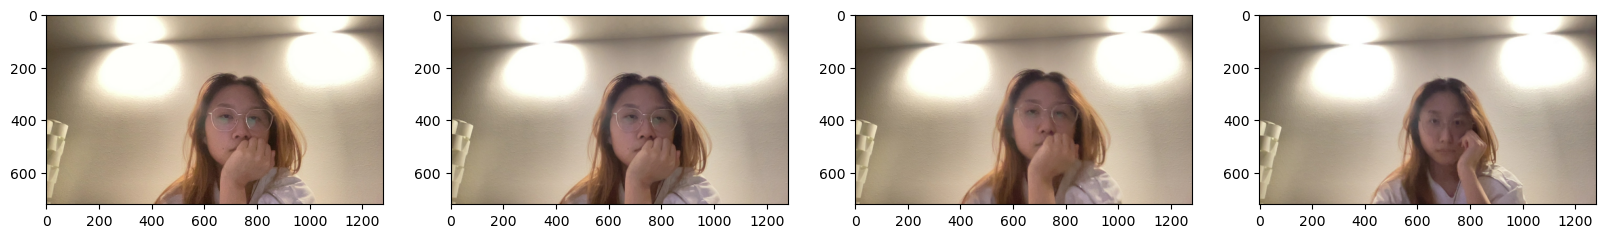

In [33]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [35]:
for folder in ['train','test','vali']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [36]:
import albumentations as alb

In [87]:
augmentor = alb.Compose([alb.RandomCrop(width=900, height=600), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [88]:
img = cv2.imread(os.path.join('data', 'train', 'images', 'xxxxxx.jpg'))

In [89]:
with open(os.path.join('data', 'train', 'labels', 'xxxxx.json'), 'r') as f:
    label = json.load(f)

In [90]:
label['shapes'][0]['points']

[[888.0769230769231, 359.03846153846155], [1140.0, 630.1923076923077]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [91]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [92]:
#coords of annotation to mark sylvia's face
coords

[888.0769230769231, 359.03846153846155, 1140.0, 630.1923076923077]

In [93]:
coords = list(np.divide(coords, [1280,720,1280,720]))

In [94]:
#coords of annotation after scaling
coords

[0.6938100961538461, 0.4986645299145299, 0.890625, 0.8752670940170941]

### 4.4 Apply Augmentations and View Results

In [95]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['sylvia'])

In [96]:
augmented['bboxes']

[(0.0, 0.0, 0.0954700854700854, 0.4149358974358974)]

In [97]:
augmented['bboxes'][0][2:]

(0.0954700854700854, 0.4149358974358974)

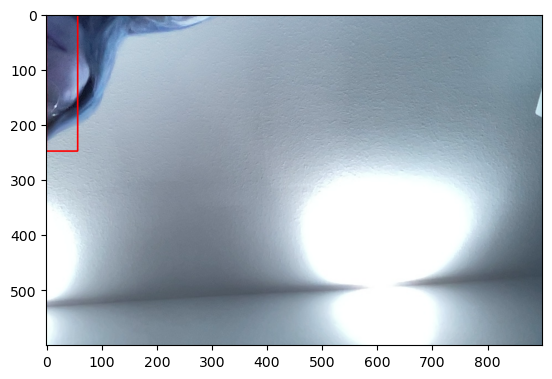

In [98]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [600,600]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [600,600]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [99]:
for partition in ['train','test','vali']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')

            
        if os.path.exists(label_path):
            # print(f"Processing label file: {label_path}")
            with open(label_path, 'r') as f:

                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1280,720,1280,720]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['sylvia'])
                write_success = cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])
                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type
x_max is less than or equal to x_min for bbox [0.1349158653846154, 0.9393696581196582, 0.0, 0.4333116136000751, 'sylvia'].
image must be numpy array type
image must be numpy array type


### 5.2 Load Augmented Images to Tensorflow Dataset

In [103]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [104]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [105]:
val_images = tf.data.Dataset.list_files('aug_data/vali/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [106]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [107]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [108]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [109]:
val_labels = tf.data.Dataset.list_files('aug_data/vali/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [110]:
train_labels.as_numpy_iterator().next()

2023-09-08 19:35:05.665178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3720]
	 [[{{node Placeholder/_0}}]]


(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [111]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3720, 3720, 840, 840, 780, 780)

### 7.2 Create Final Datasets (Images/Labels)

In [112]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(4000)
train = train.batch(8)
train = train.prefetch(4)

In [113]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(800)
test = test.batch(8)
test = test.prefetch(4)

In [114]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(800)
val = val.batch(8)
val = val.prefetch(4)

In [115]:
train.as_numpy_iterator().next()[1]

2023-09-08 19:35:18.070530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [3720]
	 [[{{node Placeholder/_5}}]]
2023-09-08 19:35:18.071440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3720]
	 [[{{node Placeholder/_0}}]]


(array([[0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1]], dtype=uint8),
 array([[0.    , 0.    , 0.    , 0.    ],
        [0.1279, 0.248 , 0.4697, 0.809 ],
        [0.    , 0.2783, 0.3345, 1.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.2522, 0.2164, 0.4253, 0.5337],
        [0.    , 0.    , 0.    , 0.    ],
        [0.245 , 0.7666, 0.64  , 1.    ],
        [0.724 , 0.5986, 0.955 , 0.9478]], dtype=float16))

### 7.3 View Images and Annotations

In [116]:
data_samples = train.as_numpy_iterator()

In [117]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


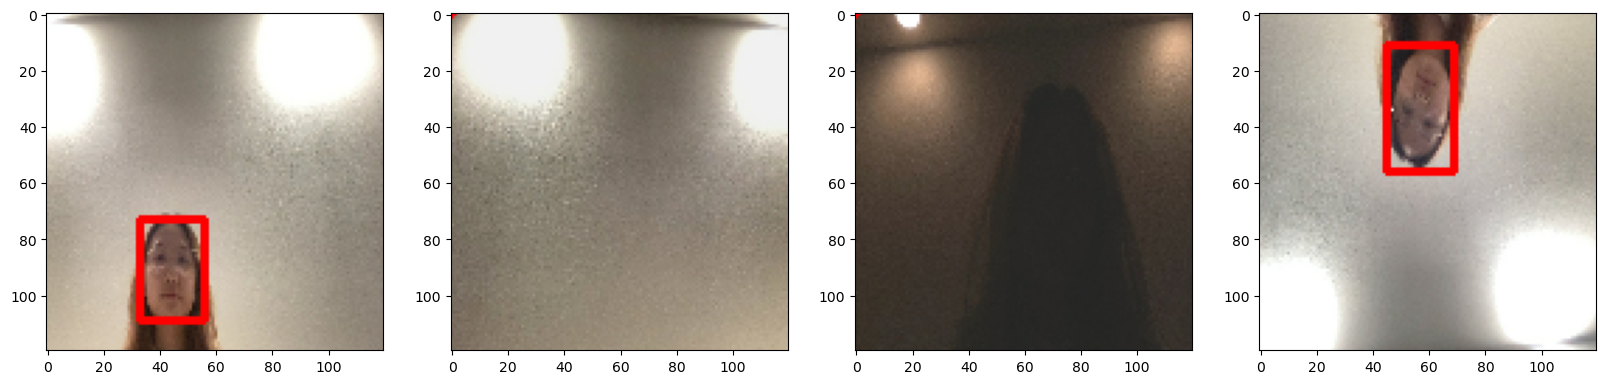

In [118]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [119]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [120]:
vgg = VGG16(include_top=False)

In [121]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [122]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [123]:
facetracker = build_model()

In [124]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [125]:
X,y = train.as_numpy_iterator().next()

In [126]:
X.shape

(8, 120, 120, 3)

In [127]:
X[1]

array([[[0.16666667, 0.09607843, 0.09411765],
        [0.12843138, 0.06960785, 0.05784314],
        [0.15980393, 0.08921569, 0.08137255],
        ...,
        [0.7245098 , 0.6617647 , 0.5598039 ],
        [0.7176471 , 0.6627451 , 0.5568628 ],
        [0.7254902 , 0.67058825, 0.5647059 ]],

       [[0.12745099, 0.06568628, 0.0627451 ],
        [0.15294118, 0.08235294, 0.06666667],
        [0.16862746, 0.09803922, 0.09019608],
        ...,
        [0.7117647 , 0.65686274, 0.5509804 ],
        [0.7235294 , 0.66862744, 0.5627451 ],
        [0.7372549 , 0.68235296, 0.5764706 ]],

       [[0.14607844, 0.08333334, 0.08333334],
        [0.16666667, 0.09607843, 0.0882353 ],
        [0.16862746, 0.09803922, 0.08235294],
        ...,
        [0.71666664, 0.6735294 , 0.5637255 ],
        [0.7352941 , 0.68039215, 0.5745098 ],
        [0.73137254, 0.67058825, 0.56764704]],

       ...,

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1

In [128]:
y[1]

array([[0.469  , 0.4167 , 0.6763 , 0.75   ],
       [0.     , 0.2073 , 0.1404 , 0.5566 ],
       [0.751  , 0.02711, 1.     , 0.601  ],
       [0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 0.     ],
       [0.1115 , 0.     , 0.479  , 0.2734 ],
       [0.4307 , 0.3108 , 0.8687 , 1.     ],
       [0.     , 0.     , 0.     , 0.     ]], dtype=float16)

In [129]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 1s/step


In [130]:
classes, coords

(array([[0.7108645 ],
        [0.728259  ],
        [0.6827212 ],
        [0.62931365],
        [0.6385835 ],
        [0.5929678 ],
        [0.66794693],
        [0.56529176]], dtype=float32),
 array([[0.46715057, 0.5391426 , 0.19213723, 0.42028064],
        [0.5009879 , 0.6261185 , 0.20226894, 0.41768566],
        [0.53300506, 0.5712201 , 0.2320321 , 0.45485675],
        [0.5872668 , 0.60415906, 0.30389494, 0.47667277],
        [0.5432705 , 0.5550107 , 0.26559746, 0.4326818 ],
        [0.5028114 , 0.629326  , 0.22026259, 0.39181444],
        [0.5108911 , 0.5593667 , 0.28991613, 0.3634081 ],
        [0.57662636, 0.59097695, 0.39357293, 0.52363986]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [131]:
len(train)

465

In [132]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [133]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [134]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [135]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [136]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=7.2452536>

In [137]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.60117555>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [138]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [139]:
model = FaceTracker(facetracker)

In [140]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [141]:
logdir='logs'

In [142]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
465/465 [==============================] - ETA: 0s - total_loss: 0.6641 - class_loss: 0.2051 - regress_loss: 0.5616

2023-09-08 19:50:43.258342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [780]
	 [[{{node Placeholder/_0}}]]
2023-09-08 19:50:43.264808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [780]
	 [[{{node Placeholder/_5}}]]


465/465 [==============================] - 925s 2s/step - total_loss: 0.6657 - class_loss: 0.2053 - regress_loss: 0.5630 - val_total_loss: 0.0552 - val_class_loss: 1.3083e-04 - val_regress_loss: 0.0551
Epoch 2/10
465/465 [==============================] - 1177s 3s/step - total_loss: 0.1946 - class_loss: 0.0811 - regress_loss: 0.1540 - val_total_loss: 0.0479 - val_class_loss: 0.0012 - val_regress_loss: 0.0473
Epoch 3/10
465/465 [==============================] - 1233s 3s/step - total_loss: 0.1273 - class_loss: 0.0512 - regress_loss: 0.1017 - val_total_loss: 0.0270 - val_class_loss: 0.0132 - val_regress_loss: 0.0204
Epoch 4/10
465/465 [==============================] - 1198s 3s/step - total_loss: 0.1037 - class_loss: 0.0404 - regress_loss: 0.0835 - val_total_loss: 0.0265 - val_class_loss: 0.0070 - val_regress_loss: 0.0231
Epoch 5/10
465/465 [==============================] - 1292s 3s/step - total_loss: 0.0790 - class_loss: 0.0343 - regress_loss: 0.0619 - val_total_loss: 0.8745 - val_clas